In [1]:
%load_ext autoreload
%autoreload 2
import pytorch_lightning as pl
import pytorch_lightning.callbacks as pl_callbacks
import torch
import eq


## Loading the catalog

By default, all catalogs are saved to the following directory

In [2]:
print(eq.data.default_catalogs_dir)

/home/zekai/repos/recast/data


We load the catalog constructed by White et al. The catalog records earthquakes between `2008-01-01` and `2021-01-01`.
The following code automatically downloads and preprocesses the catalog, or loads it from the data directory, if it's already there.

In [19]:
catalog = eq.catalogs.ANSS_MultiCatalog(mag_completeness=4.5)

Loading existing catalog from /home/zekai/repos/recast/data/ANSS_MultiCatalog.


Other available catalogs:
- `eq.catalogs.SCEDC`
- `eq.catalogs.QTMSanJacinto`
- `eq.catalogs.QTMSaltonSea`

### Representing the data
We can represent all data stored in the catalog as an object of type `eq.data.Sequence`.

In [20]:
catalog.full_sequence

AttributeError: 'ANSS_MultiCatalog' object has no attribute 'full_sequence'

An `eq.data.Sequence` object contains the following attributes:
- `t_start` and `t_end`: Start and end of the time interval containing the events (in days).
- `arrival_times`: Arrival times of each event (in days), shape `[num_events]`
- `inter_times`: Inter-event times, shape `[num_events + 1]` since this also includes the last survival time from `arrival_times[-1]` until `t_end`.
- `mag`: Magnitude of each earthquake, shape `[num_events]`.
- `t_nll_start`: This attributed allows to compute the negative log-likelihood (NLL) only for the observations in the interval `[t_nll_start, t_end]`, while conditioning the model on past events in `[t_start, t_nll_start]`.

In [21]:
eq.visualization.visualize_sequence(catalog.full_sequence)

AttributeError: 'ANSS_MultiCatalog' object has no attribute 'full_sequence'

### Train / val / test split

To compare different models, we split the full event sequence into 3 components:
- `train`: used for training the models, includes events between `2008-01-01` and `2014-01-01`.
- `val`: used for early stopping and hyperparameter selection, includes events between `2014-01-01` and `2017-01-01`.
- `test`: used for final evaluation, includes events between `2017-01-01` and `2021-01-01`.

We already provided the start of the val and test intervals when loading the catalog, so now the train, val and test sequences are stored in `catalog.train`, `catalog.val` and `catalog.test`, respectively.

In our case the catalog consists of a single event sequence but, in principle, there could be multiple event sequences stored in `catalog.train`, `catalog.val` and `catalog.test`.

In [22]:
print("Train sequence:")
print(catalog.train[0])
print("\nValidation sequence:")
print(catalog.val[0])
print("\nTest sequence:")
print(catalog.test[0])

Train sequence:
Sequence(
  inter_times: [319],
  arrival_times: [318],
  t_start: 0.0,
  t_end: 365.0,
  t_nll_start: 0.0,
  mag: [318],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)

Validation sequence:
Sequence(
  inter_times: [2329],
  arrival_times: [2328],
  t_start: 0.0,
  t_end: 365.0,
  t_nll_start: 0.0,
  mag: [2328],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)

Test sequence:
Sequence(
  inter_times: [120],
  arrival_times: [119],
  t_start: 0.0,
  t_end: 365.0,
  t_nll_start: 0.0,
  mag: [119],
  mag_bounds: [2],
  mag_nll_bounds: [2]
)


Note that, for example, the `test` sequence contains all events in the catalog, including the training set.

However, since we specified `t_nll_start`, the model will know to only compute the NLL on the interval `[t_nll_start, t_end]` (shown in orange in the figure below), while also conditioning on the events from `[0, t_nll_start]`.

<Axes: xlabel='Time (days)', ylabel='Magnitude'>

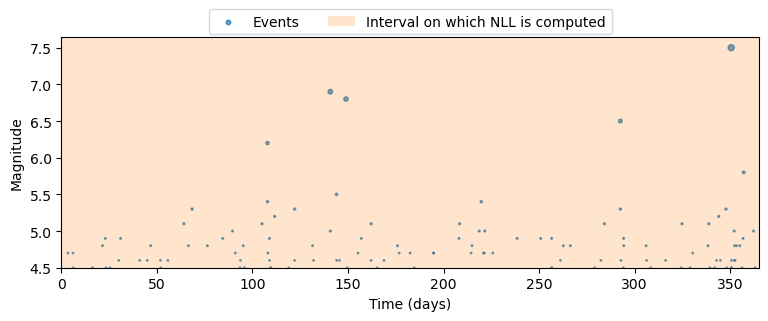

In [23]:
eq.visualization.visualize_sequence(catalog.test[0], show_nll=True)

## Training the model

We will train the model using the high-level API provided by `pytorch_lightning`.

For this, we first need to create `torch.utils.data.DataLoader` objects that will feed the data into the model.

In [28]:
dl_train = catalog.train.get_dataloader()
dl_val = catalog.val.get_dataloader()
dl_test = catalog.test.get_dataloader()

Now, we initialize the model.

In [29]:
model = eq.models.ETAS()

`pytorch_lightning.Trainer` takes care of training the model, early stopping and saving the best weights.

In this toy example, we set `max_epochs=200` and `patience=20` to get to the results more quickly.

In the experiments in the paper, we trained the models for longer with `max_epochs=1500` and `patience=200`.

In [30]:
# ModelCheckpoints saves the model with the best validation loss
checkpoint = pl_callbacks.ModelCheckpoint(monitor="val_loss")

# EarlyStopping stops training if the validation loss doesn't improve by more than 1e-3 for 20 epochs
early_stopping = pl_callbacks.EarlyStopping(monitor="val_loss", patience=20, min_delta=1e-3)

# RichProgressBar adds a nice and more functional progress bar
progress_bar = pl_callbacks.RichProgressBar()

num_gpus = int(torch.cuda.is_available())  # equals to 1 if GPU is available, 0 otherwise
trainer = pl.Trainer(devices=num_gpus,max_epochs=200, callbacks=[checkpoint, early_stopping, progress_bar])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [31]:
trainer.fit(model, dl_train, dl_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┓
┃   ┃ Name         ┃ Type ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━┩
│   │ other params │ n/a  │      5 │
└───┴──────────────┴──────┴────────┘

Trainable params: 5                                                                                                
Non-trainable params: 0                                                                                            
Total params: 5                                                                                                    
Total estimated model params size (MB): 0

Output()

/home/zekai/miniconda3/envs/eq/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:
441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of 
the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

/home/zekai/miniconda3/envs/eq/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:
441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of 
the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

## Evaluation

Load the model with the best validation loss

In [33]:
model = eq.models.ETAS.load_from_checkpoint(checkpoint.best_model_path)

After training the model, we compute the loss on the negative log-likelihood (NLL) loss on the test set.

In [34]:
trainer.test(model, dl_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/home/zekai/miniconda3/envs/eq/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.2712879180908203     │
│      total_test_loss      │    0.2712879180908203     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2712879180908203, 'total_test_loss': 0.2712879180908203}]